In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from src.data_utils.loader import DataLoader

In [21]:
gold_panel_path = "data/processed/gold_panel"
ff5_features = ['mvel1', 'bm', 'mom12m', 'mom1m', 'retvol'] # Not fama french 5, i think

loader = DataLoader(data_path = gold_panel_path)
df = loader.load_panel_data()

[2026-02-12 00:13:04] [INFO] [ParquetLoader] REQ: Loading ALL columns...
[2026-02-12 00:13:04] [INFO] [ParquetLoader] SOURCE: data/processed/gold_panel
[2026-02-12 00:13:24] [INFO] [ParquetLoader] LOAD COMPLETE. Shape: (4065278, 100) | RAM: 1.65 GB


# Stat Properties

In [22]:
df['target_ret_excess'].describe()

count    4.065278e+06
mean     7.491225e-03
std      1.747678e-01
min     -1.000000e+00
25%     -6.439100e-02
50%     -2.700000e-03
75%      6.236700e-02
max      2.399660e+01
Name: target_ret_excess, dtype: float64

In [23]:
(np.abs(df['target_ret_excess']) > 2).mean()

np.float64(0.0003716842980972027)

In [24]:
y = df['target_ret_excess'].values
threshold = np.quantile(np.abs(y), 0.999)
big = np.abs(y) > threshold

np.sum(y[big]**2) / np.sum(y**2)

np.float32(0.21952768)

In [25]:
df[df['target_ret_excess'] > 2].sort_values(by='target_ret_excess', ascending=False)

,permno,date,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,mom1m,...,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2,target_ret_excess,mktcap_next,year
1644951,58748,1991-12-31,-0.967257,-0.950541,-0.728463,-0.788058,-0.948260,0.977049,-0.145572,0.253722,...,-0.962914,-0.943274,-0.971083,0.954233,-0.046532,0.634114,65.0,23.996599,18.965626,1991
3852292,16400,2018-12-31,-0.159965,-0.962756,-0.983985,0.181902,-0.980212,-0.948603,0.525190,-0.698735,...,0.976182,0.857833,0.696928,0.790128,-0.996204,0.990162,99.0,19.881491,8115.943359,2018
1773871,53154,1993-07-30,-0.987584,0.065673,0.062183,-0.797178,-0.977901,0.500634,-0.604523,0.909752,...,0.968153,0.961109,0.970974,0.459850,-0.490266,0.936938,99.0,18.997499,1.233125,1993
3991766,48072,2020-12-31,-0.924975,-0.535062,-0.540541,0.804781,-0.931549,0.814098,0.904135,-0.705455,...,0.963278,-0.579193,-0.340905,0.782899,-0.909895,0.908606,36.0,17.604650,487.424011,2020
2034785,25559,1996-04-30,-0.425599,0.990000,0.990000,-0.882630,-0.669061,0.990000,-0.167602,0.989795,...,0.690289,0.990065,0.990048,-0.497009,-0.570977,0.086931,99.0,16.995800,335.019379,1996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3652116,12078,2016-01-29,-0.906897,-0.148401,-0.151728,0.902090,-0.766522,0.953428,-0.467759,-0.644352,...,0.795517,0.500345,0.394138,0.385305,-0.487586,0.530345,38.0,2.005973,39.870689,2016
2910346,85540,2005-08-31,-0.989603,-0.990147,-0.511872,0.495878,-0.380252,0.920853,0.451508,-0.032721,...,0.759251,0.972523,0.966989,0.826126,0.990045,-0.972371,30.0,2.002914,10.526120,2005
3937333,14556,2020-03-31,-0.716156,0.959041,0.957565,-0.683863,-0.180038,0.885609,0.816977,-0.426346,...,0.441323,0.587668,0.737015,-0.175638,0.598622,-0.730875,36.0,2.001346,84.632957,2020
2413826,82810,1999-11-30,0.075274,0.381632,0.381632,-0.990008,0.741310,0.920346,0.723440,-0.857108,...,-0.662771,0.009528,0.376029,-0.796420,0.913209,-0.977603,73.0,2.000295,497.640015,1999


## Empirical PDF

In [26]:
# Get the 0.05th and 99.95th percentiles to exclude extreme tails
lower_bound = df['target_ret_excess'].quantile(0.0005)
upper_bound = df['target_ret_excess'].quantile(0.9995)

filtered_df = df['target_ret_excess'][
    (df['target_ret_excess'] >= lower_bound) & (df['target_ret_excess'] <= upper_bound)
]


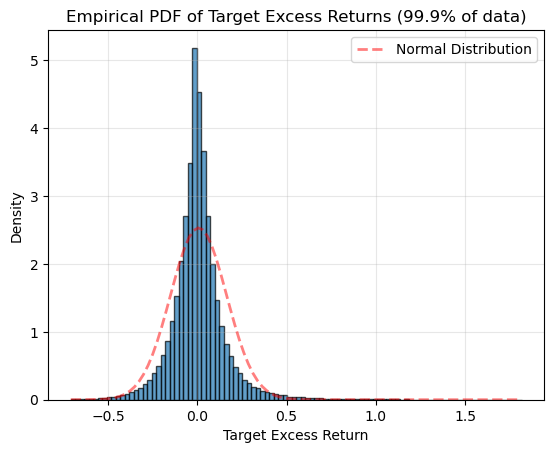

In [27]:
mu = filtered_df.mean()
sigma = filtered_df.std()
x = np.linspace(filtered_df.min(), filtered_df.max(), 100)
normal_pdf = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

plt.hist(filtered_df, bins=100, density=True, alpha=0.7, edgecolor='black')
plt.plot(x, normal_pdf, 'r--', linewidth=2, alpha=0.5, label='Normal Distribution')
plt.xlabel('Target Excess Return')
plt.ylabel('Density')
plt.title('Empirical PDF of Target Excess Returns (99.9% of data)')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Empirical CDF

c:\Users\rcorr\anaconda3\envs\asset_pricing\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


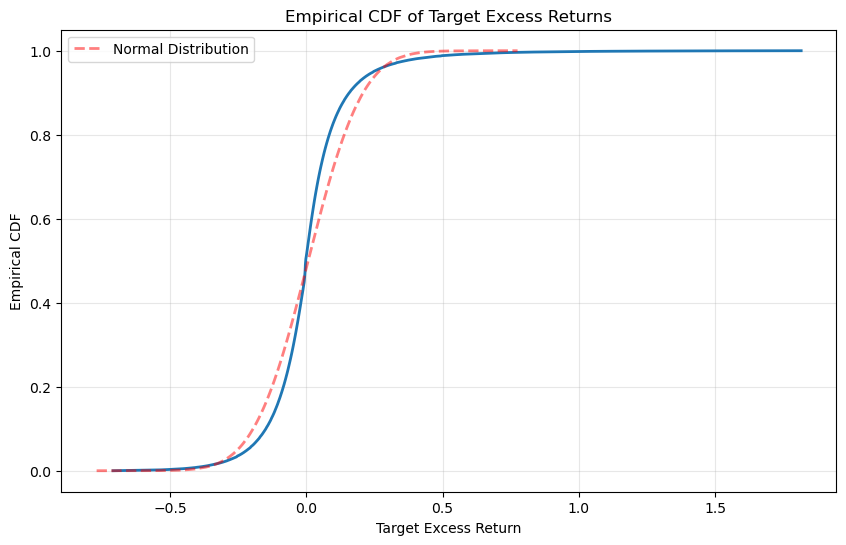

In [28]:
sorted_data = np.sort(filtered_df.dropna())
norm_cdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
ecdf = np.arange(1, len(sorted_data) + 1) / len(sorted_data)

plt.figure(figsize=(10, 6))
plt.plot(sorted_data, ecdf, linewidth=2)
plt.plot(np.sort(np.random.normal(mu, sigma, len(sorted_data))), norm_cdf, 'r--', linewidth=2, alpha=0.5, label='Normal Distribution')
plt.xlabel('Target Excess Return')
plt.ylabel('Empirical CDF')
plt.title('Empirical CDF of Target Excess Returns')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## QQ Plot

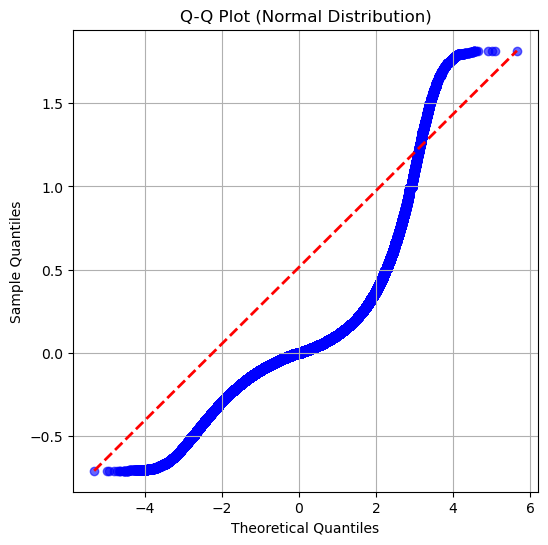

In [29]:
n_samples = len(filtered_df)
std_norm = np.random.standard_normal(n_samples)
sorted_std_norm = np.sort(std_norm)

plt.figure(figsize=(6, 6))
plt.scatter(sorted_std_norm, sorted_data, color='blue', alpha=0.6)
plt.plot(
    [sorted_std_norm.min(), sorted_std_norm.max()],
    [sorted_data.min(), sorted_data.max()],
    'r--', linewidth=2
)
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.title('Q-Q Plot (Normal Distribution)')
plt.grid(True)
plt.show()

## Stochastic Process Analysis

In [30]:
df.columns

Index(['permno', 'date', 'mvel1', 'beta', 'betasq', 'chmom', 'dolvol',
       'idiovol', 'indmom', 'mom1m', 'mom6m', 'mom12m', 'mom36m', 'pricedelay',
       'turn', 'absacc', 'acc', 'age', 'agr', 'bm', 'bm_ia', 'cashdebt',
       'cashpr', 'cfp', 'cfp_ia', 'chatoia', 'chcsho', 'chempia', 'chinv',
       'chpmia', 'convind', 'currat', 'depr', 'divi', 'divo', 'dy', 'egr',
       'ep', 'gma', 'grcapx', 'grltnoa', 'herf', 'hire', 'invest', 'lev',
       'lgr', 'mve_ia', 'operprof', 'orgcap', 'pchcapx_ia', 'pchcurrat',
       'pchdepr', 'pchgm_pchsale', 'pchquick', 'pchsale_pchinvt',
       'pchsale_pchrect', 'pchsale_pchxsga', 'pchsaleinv', 'pctacc', 'ps',
       'quick', 'rd', 'rd_mve', 'rd_sale', 'realestate', 'roic', 'salecash',
       'saleinv', 'salerec', 'secured', 'securedind', 'sgr', 'sin', 'sp',
       'tang', 'tb', 'aeavol', 'cash', 'chtx', 'cinvest', 'ear', 'nincr',
       'roaq', 'roavol', 'roeq', 'rsup', 'stdacc', 'stdcf', 'ms', 'baspread',
       'ill', 'maxret', 'retvol', '